In [1]:
import numpy as np
from mcmc.mcmc import PartitionMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore

# for reproducibility
# np.random.seed(32205)

In [2]:
num_nodes = 10
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

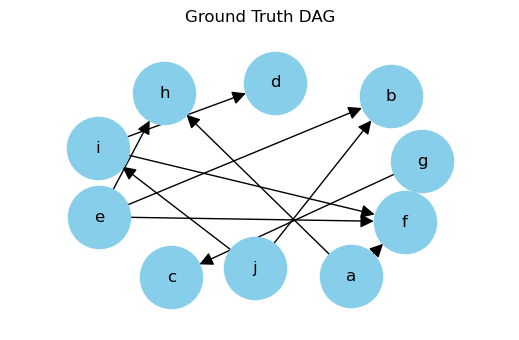

In [3]:
# visualise ground truth DAG
from mcmc.utils.graph_utils import plot_graph_from_adj_mat
plot_graph_from_adj_mat(synthetic_data.adj_mat.values, node_labels, title="Ground Truth DAG")

In [4]:
synthetic_data.data

,a,b,c,d,e,f,g,h,i,j
0,-0.281031,-2.164997,0.225221,-0.136817,0.848412,6.051476,0.236617,1.392374,2.199857,0.584999
1,0.023645,-3.950316,-0.908840,-4.287057,-0.993073,7.956317,0.846073,-0.875925,6.543757,3.116501
2,0.055200,-2.102547,0.106382,2.194481,1.831518,1.566093,-0.296124,2.455375,-2.404809,-0.702792
3,-0.062669,-0.556983,0.133659,1.733201,0.026242,-3.302390,0.077448,-0.502710,-2.428575,0.066066
4,-0.356250,4.066348,1.054502,0.148420,-1.536604,-2.853498,0.034637,-2.663464,-0.373673,-0.049794
...,...,...,...,...,...,...,...,...,...,...
195,-0.130445,2.361566,0.708070,2.263326,0.533640,-3.869571,0.643215,0.006626,-4.139168,-1.814384
196,-0.459466,7.543599,-0.094278,2.846263,-0.370765,-5.816481,0.203908,0.273108,-3.956621,-2.593086
197,-0.295702,0.677390,1.352230,0.631276,0.311369,-0.485298,-0.766952,1.341026,-0.482054,-0.191124
198,1.216247,-0.483087,1.146071,-0.530327,0.337689,4.734022,-1.059536,0.384035,1.171798,-0.145051


In [5]:
# setup random initial graph

initial_graph = np.random.choice([0,1], size=(num_nodes, num_nodes))*np.tri(num_nodes, num_nodes, -1)
p = np.random.permutation(num_nodes)
# shuffle
initial_graph = initial_graph[p, :]
initial_graph = initial_graph[:, p]

In [6]:
# setup mcmc
from mcmc.utils.partition_utils import build_partition

n_iterations = 100000
score = BGeScore(synthetic_data.data, initial_graph)

partition = build_partition(incidence=initial_graph, node_labels=list(synthetic_data.data.columns))
proposal = PartitionProposal(partition)

M = PartitionMCMC(init_part=partition, max_iter=10000, proposal_object=proposal, score_object=score)

Pre Scoring Nodes...


In [7]:
# run experiment

mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Initialise:  0.00000
Acceptance_ratio: 0.0453


In [8]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

BURN_IN = 0.2

graphs = M.get_mcmc_res_graphs(mcmc_results)

key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)
print(key in keys)

True


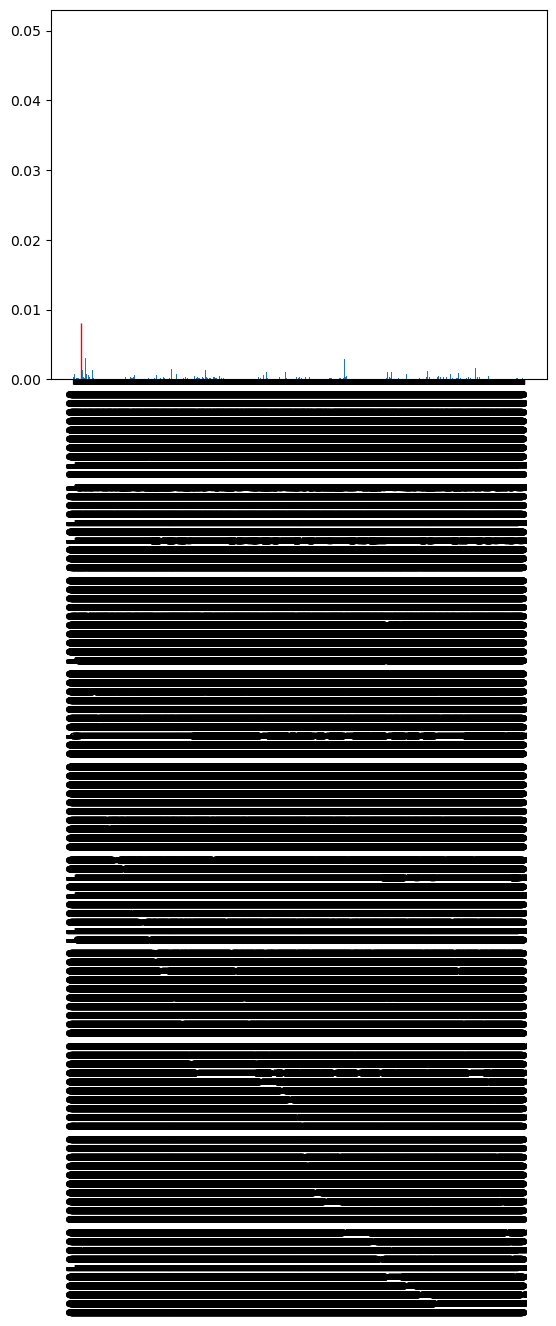

In [9]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/len(graphs))
plt.xticks(range(len(keys)), keys, rotation=90);
bars[np.where(keys==key)[0][0]].set_color('red')

-2931.7712001439972


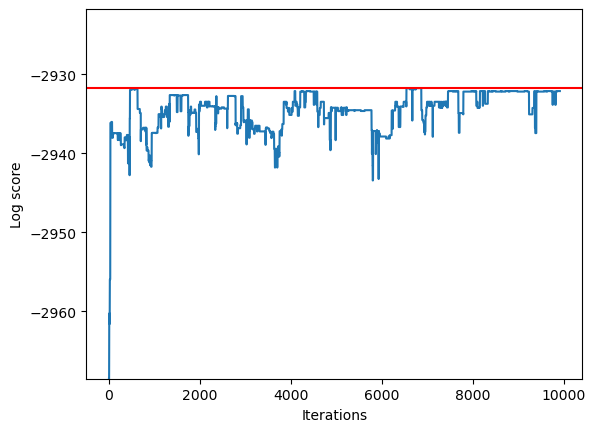

In [11]:
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy
from mcmc.utils.score_utils import partition_score

def get_mcmc_scores(results):
        mcmc_graph_lst = []
        for i in results:
            mcmc_graph_lst.append( results[i]['score_P_curr'] )
        return mcmc_graph_lst
scores = get_mcmc_scores(mcmc_results)

true_partition = build_partition(incidence=synthetic_data.adj_mat.values, node_labels=list(synthetic_data.data.columns))
party_curr, permy_curr, posy_curr = convert_partition_to_party_permy_posy(true_partition)
true_score = partition_score(M.node_labels, M.node_labels, M.parent_table, M.score_table, permy_curr, party_curr, posy_curr )
true_score = sum(true_score['total_scores'].values())
plt.plot(range(len(scores)), scores)
plt.axhline(true_score, color='r')
plt.ylim(min(scores), true_score+10)
plt.xlabel('Iterations')
plt.ylabel('Log score')
print(true_score)